In [1]:
import pandas as pd
import ast

# Load metadata CSV
df_meta = pd.read_csv("Dataset/ptbxl/ptbxl_database.csv")
# Convert the string of dict in 'scp_codes' to an actual dictionary object
df_meta['scp_codes'] = df_meta['scp_codes'].apply(lambda x: ast.literal_eval(x))
print(df_meta.iloc[0])  # print the first record's metadata as example

ecg_id                                                                 1
patient_id                                                       15709.0
age                                                                 56.0
sex                                                                    1
height                                                               NaN
weight                                                              63.0
nurse                                                                2.0
site                                                                 0.0
device                                                         CS-12   E
recording_date                                       1984-11-09 09:17:34
report                            sinusrhythmus periphere niederspannung
scp_codes                       {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
heart_axis                                                           NaN
infarction_stadium1                                

In [3]:
# Identify which records have an MI diagnosis
# Load mapping of SCP codes to diagnostic superclasses
agg_df = pd.read_csv("Dataset/ptbxl/scp_statements.csv")
agg_df = agg_df[agg_df['diagnostic'] == 1]  # consider only diagnostic statements
# Create a helper function to determine if a record is MI
mi_superclass = 'MI'
def has_MI(scp_dict):
    classes = {agg_df.loc[code]["diagnostic_class"] 
               for code in scp_dict.keys() if code in agg_df.index}
    return (mi_superclass in classes)

df_meta['is_mi'] = df_meta['scp_codes'].apply(has_MI)
df_meta['is_mi'].value_counts()


is_mi
False    21837
Name: count, dtype: int64

In [7]:
!pip install wfdb pandas matplotlib scikit-learn
import wfdb

# Base path where data is stored:
base_path = "Dataset/ptbxl/"  
record_path = base_path + df_meta.loc[0, 'filename_hr']  # path of first record
signals, fields = wfdb.rdsamp(record_path)
print("Signal shape:", signals.shape)
print("Sampling frequency:", fields['fs'], "Hz")
print("Signal channels:", fields['sig_name'])

Signal shape: (5000, 12)
Sampling frequency: 500 Hz
Signal channels: ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']


In [9]:
from scipy.signal import butter, filtfilt
import numpy as np

# Design a Butterworth bandpass filter (0.5-40 Hz for 500 Hz sampling)
fs = 500.0
lowcut, highcut = 0.5, 40.0
nyq = 0.5 * fs
b, a = butter(N=4, Wn=[lowcut/nyq, highcut/nyq], btype='band')  # 4th order bandpass

# Example: filter the signals of the first record
sig = signals.copy()  # signals from earlier wfdb.rdsamp example
sig_filt = filtfilt(b, a, sig, axis=0)  # apply along each lead (axis 0 = time)
# Remove any DC offset (though high-pass should remove most)
sig_centered = sig_filt - np.mean(sig_filt, axis=0)
# Normalize to unit variance
sig_norm = sig_centered / np.std(sig_centered, axis=0)

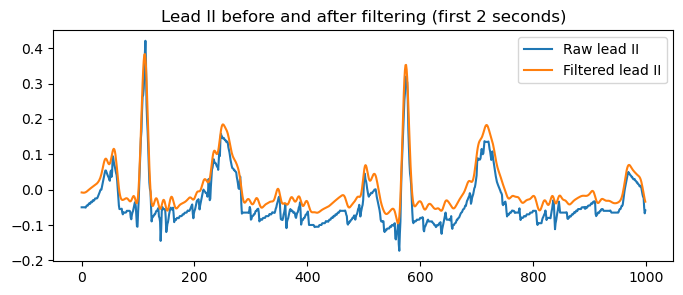

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))
plt.plot(sig[:1000,1], label="Raw lead II")
plt.plot(sig_filt[:1000,1], label="Filtered lead II")
plt.legend(); plt.title("Lead II before and after filtering (first 2 seconds)"); plt.show()

In [11]:
from scipy.signal import find_peaks

# Assume sig_norm (after filtering) is our processed signal for a single record.
# Use lead II (index 1) for R-peak detection:
lead = 1
ecg_lead = sig_norm[:, lead]

# Find peaks above a certain threshold (to avoid picking up noise)
peaks, properties = find_peaks(ecg_lead, height=0.5, distance=150)  
# height=0.5 (in normalized units ~0.5 mV) and distance=150 (=> 150 samples at 500Hz ~300ms, to avoid double detections)
print("Detected R-peak indices:", peaks)

Detected R-peak indices: [ 112  575 1039 1501 1966 2438 2914 3395 3867 4323 4495 4805]


In [12]:
import numpy as np

def extract_time_domain_features(signal, fs=500):
    """Extract time-domain features from a single-record 2D array (samples x 12 leads)."""
    features = {}
    # Use lead II for heart rate & intervals
    lead = 1
    x = signal[:, lead]
    # R-peaks detection (use the approach from above)
    peaks, _ = find_peaks(x, height=np.max(x)*0.5, distance=int(0.3*fs))
    if len(peaks) < 2:
        return None  # cannot compute features if fewer than 2 beats detected
    rr_intervals = np.diff(peaks) / fs  # in seconds
    heart_rate = 60.0 / np.mean(rr_intervals)  # beats per minute
    features['heart_rate'] = heart_rate
    features['rr_interval_mean'] = np.mean(rr_intervals) * 1000  # in ms
    features['rr_interval_sd'] = np.std(rr_intervals) * 1000     # in ms
    
    # QRS duration: approximate (in ms)
    qrs_durations = []
    for p in peaks:
        # find QRS onset (go backwards)
        i = p
        baseline_val = signal[p, lead]  # value at R peak (should be high)
        # move left until crosses near 0 or until 150ms back
        while i > 0 and signal[i, lead] > 0.1 and (p - i) < 0.15*fs:
            i -= 1
        qrs_on = i
        # find QRS offset (go forward)
        j = p
        while j < signal.shape[0] and signal[j, lead] > 0.1 and (j - p) < 0.15*fs:
            j += 1
        qrs_off = j
        dur = (qrs_off - qrs_on) / fs * 1000.0  # in ms
        qrs_durations.append(dur)
    features['qrs_dur_mean'] = np.mean(qrs_durations)
    
    # ST elevation in lead II (mV): difference between value ~60ms after R and ~ before QRS
    st_elevations = []
    for p in peaks:
        idx_st = p + int(0.06*fs)
        idx_base = p - int(0.05*fs) if p - int(0.05*fs) >= 0 else p
        if idx_st < signal.shape[0]:
            st_elev = signal[idx_st, lead] - signal[idx_base, lead]
            st_elevations.append(st_elev)
    features['st_elev_mean_leadII'] = np.mean(st_elevations) if st_elevations else 0.0
    
    # T-wave inversion in lead II: check if T peak is negative
    t_inverted = 0
    for p, next_p in zip(peaks, peaks[1:]):  # iterate pairs of consecutive R-peaks
        # search T wave roughly in middle of RR interval
        mid = p + int(0.4*fs)  # roughly 400ms after R (should cover T in normal cases)
        end = min(next_p, p + int(0.6*fs))
        segment = signal[p+int(0.1*fs): end, lead]  # 100ms after R to mid RR
        if len(segment) == 0:
            continue
        if np.max(segment) < 0 and np.min(segment) < 0:
            t_inverted = 1
            break
    features['t_inverted_leadII'] = t_inverted
    return features

# Example usage on first record signal:
time_feats = extract_time_domain_features(sig_norm, fs=500)
print(time_feats)

{'heart_rate': 63.9249946729171, 'rr_interval_mean': 938.6000000000001, 'rr_interval_sd': 16.420718620084777, 'qrs_dur_mean': 42.90909090909091, 'st_elev_mean_leadII': 0.09896429138268789, 't_inverted_leadII': 0}


In [13]:
import numpy.fft as fft

def compute_band_powers(signal, fs=500.0, lead=1):
    x = signal[:, lead]
    n = len(x)
    # Compute FFT and power spectral density
    X = fft.rfft(x)  # rfft gives positive frequencies
    freqs = fft.rfftfreq(n, d=1/fs)
    power = np.abs(X)**2 / n  # power spectrum (not formally PSD without normalization by fs, but relative power okay)
    # Define bands in Hz
    bands = {'VLF': (0.0, 0.5), 'LF': (0.5, 4.0), 'MF': (4.0, 15.0), 'HF': (15.0, 40.0)}
    band_powers = {}
    for band, (low, high) in bands.items():
        # Integrate power in [low, high] Hz
        mask = (freqs >= low) & (freqs < high)
        band_powers[f'power_{band}'] = power[mask].sum()
    # We can also include total power or ratios if needed
    band_powers['power_total'] = power[(freqs >= 0.5) & (freqs < 40)].sum()
    return band_powers

band_feats = compute_band_powers(sig_norm, fs=500.0, lead=1)
print(band_feats)

{'power_VLF': 2.3439232215776853, 'power_LF': 879.7840405923571, 'power_MF': 1267.5581949742527, 'power_HF': 348.97771346734646, 'power_total': 2496.319949033956}


In [14]:
import numpy as np
from scipy import stats

def extract_statistical_features(signal):
    feats = {}
    # Per-lead stats
    means = np.mean(signal, axis=0)
    stds = np.std(signal, axis=0)
    skews = stats.skew(signal, axis=0, bias=False)
    kurts = stats.kurtosis(signal, axis=0, bias=False)
    # Basic stats on lead II
    feats['mean_leadII'] = means[1]
    feats['std_leadII'] = stds[1]
    feats['skew_leadII'] = skews[1]
    feats['kurtosis_leadII'] = kurts[1]
    # Aggregate stats across all 12 leads
    feats['mean_all_leads'] = np.mean(means)
    feats['std_all_leads'] = np.mean(stds)
    feats['skew_all_leads'] = np.mean(skews)
    feats['kurtosis_all_leads'] = np.mean(kurts)
    # Additionally, overall signal range or 95th percentile could be features
    feats['max_amp_leadII'] = np.max(signal[:,1])
    feats['min_amp_leadII'] = np.min(signal[:,1])
    return feats

stat_feats = extract_statistical_features(sig_norm)
print(stat_feats)

{'mean_leadII': -1.261435400579103e-16, 'std_leadII': 0.9999999999999999, 'skew_leadII': 2.2027954421772824, 'kurtosis_leadII': 5.752157049621381, 'mean_all_leads': -1.6256903231000785e-17, 'std_all_leads': 0.999999999999999, 'skew_all_leads': 0.3751119546389497, 'kurtosis_all_leads': 13.09231683205597, 'max_amp_leadII': 5.13741816242939, 'min_amp_leadII': -1.7123116091171198}


In [16]:
def extract_morphological_features(signal, r_peaks, qrs_on_off, fs=500):
    feats = {}
    lead = 1  # lead II
    # R-peak amplitudes in lead II
    r_amps = signal[r_peaks, lead] if len(r_peaks)>0 else np.array([0])
    feats['R_amp_leadII'] = float(np.mean(r_amps))
    # Max R amplitude among all leads (for each beat, find max across 12 leads, then average)
    max_r_all_leads = []
    for p in r_peaks:
        if p < signal.shape[0]:
            max_r_all_leads.append(np.max(signal[p, :]))
    feats['R_amp_max_all_leads'] = float(np.mean(max_r_all_leads)) if max_r_all_leads else 0.0
    
    # QRS area in lead II (integral of absolute QRS)
    qrs_areas = []
    for (on, off) in qrs_on_off:
        segment = signal[on:off, lead]
        area = np.trapz(np.abs(segment), dx=1.0/fs)  # numerical integration (mV*sec)
        qrs_areas.append(area * 1000)  # convert to mV*ms
    feats['QRS_area_leadII'] = float(np.mean(qrs_areas)) if qrs_areas else 0.0
    
    # T-wave amplitude in lead II: take max value in the window after QRS (just for first beat as example or average)
    t_amps = []
    for (on, off), p in zip(qrs_on_off, r_peaks):
        # look from QRS offset to QRS offset + ~300ms
        start = off
        end = min(off + int(0.3*fs), signal.shape[0])
        if start < end:
            t_amps.append(np.max(signal[start:end, lead]) - np.min(signal[start:end, lead]))
    feats['T_wave_amp_range_leadII'] = float(np.mean(t_amps)) if t_amps else 0.0
    return feats

# Using previous detection results for the example record:
r_peaks = peaks  # from find_peaks earlier
qrs_on_off = [(max(p-int(0.05*500), 0), min(p+int(0.05*500), sig_norm.shape[0])) for p in r_peaks]  # 50ms around R as placeholder
morph_feats = extract_morphological_features(sig_norm, r_peaks, qrs_on_off)
print(morph_feats)

{'R_amp_leadII': 4.441359957768131, 'R_amp_max_all_leads': 6.173216210484838, 'QRS_area_leadII': 139.81216390585558, 'T_wave_amp_range_leadII': 3.1297999225049282}


In [17]:
feature_rows = []
for idx, row in df_meta.iterrows():
    record_id = row['ecg_id']
    file = base_path + row['filename_hr']
    # Load signal
    try:
        sig, fields = wfdb.rdsamp(file)
    except Exception as e:
        print(f"Could not read record {record_id}: {e}")
        continue
    # Preprocess
    sig = filtfilt(b, a, sig, axis=0)
    sig = sig - np.mean(sig, axis=0)
    sig = sig / np.std(sig, axis=0)
    # Extract features
    time_feats = extract_time_domain_features(sig, fs=fields['fs'])
    if time_feats is None:
        # Skip if no peaks (could happen if flatline or too noisy)
        continue
    freq_feats = compute_band_powers(sig, fs=fields['fs'], lead=1)
    stat_feats = extract_statistical_features(sig)
    # For morphological, we need R peaks and QRS on/off from time_feats function.
    # We could modify extract_time_domain_features to also return R_peaks and QRS on/off indices.
    # Assuming we did that:
    r_peaks = time_feats.pop('r_peaks')  # hypothetical
    qrs_windows = time_feats.pop('qrs_windows')  # hypothetical QRS intervals
    morph_feats = extract_morphological_features(sig, r_peaks, qrs_windows, fs=fields['fs'])
    # Combine all feature dicts
    feat_dict = {'record_id': record_id}
    feat_dict.update(time_feats)
    feat_dict.update(freq_feats)
    feat_dict.update(stat_feats)
    feat_dict.update(morph_feats)
    feat_dict['is_mi'] = 1 if row['scp_codes'] and has_MI(row['scp_codes']) else 0
    feature_rows.append(feat_dict)

# Create DataFrame
df_features = pd.DataFrame(feature_rows)
print("Feature matrix shape:", df_features.shape)
print(df_features.columns)
df_features.head()

KeyError: 'r_peaks'